# Lab 4: EM Algorithm and Single-Cell RNA-seq Data

### Name: Your Name Here (Your netid here)

### Due April 2, 2021 11:59 PM

#### Preamble (Don't change this)

## Important Instructions - 

1. Please implement all the *graded functions* in main.py file. Do not change function names in main.py.
2. Please read the description of every graded function very carefully. The description clearly states what is the expectation of each graded function. 
3. After some graded functions, there is a cell which you can run and see if the expected output matches the output you are getting. 
4. The expected output provided is just a way for you to assess the correctness of your code. The code will be tested on several other cases as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%run main.py

In [3]:
module = Lab4()

## Part 1 : Expectation-Maximization (EM) algorithm for transcript quantification

## Introduction

The EM algorithm is a very helpful tool to compute maximum likelihood estimates of parameters in models that have some latent (hidden) variables.
In the case of the transcript quantification problem, the model parameters we want to estimate are the transcript relative abundances $\rho_1,...,\rho_K$.
The latent variables are the read-to-transcript indicator variables $Z_{ik}$, which indicate whether the $i$th read comes from the $k$th transcript (in which case $Z_{ik}=1$.

In this part of the lab, you will be given the read alignment data.
For each read and transcript pair, it tells you whether the read can be mapped (i.e., aligned) to that transcript.
Using the EM algorithm, you will estimate the relative abundances of the trascripts.


### Reading read transcript data - We have 30000 reads and 30 transcripts

In [4]:
n_reads=30000
n_transcripts=30
read_mapping=[]
with open("read_mapping_data.txt",'r') as file :
    lines_reads=file.readlines()
for line in lines_reads :
    read_mapping.append([int(x) for x in line.split(",")])

In [10]:
print(read_mapping[:30])
print(len(read_mapping))

[[7, 8, 9], [2], [20], [5], [3], [17], [25], [7, 8, 9], [6, 8, 9], [21, 23], [21, 22], [21, 23], [20], [21, 22], [19, 20], [0, 1], [2, 3], [2, 3], [14], [21, 23], [19, 20], [2], [29], [0, 1], [0, 1], [12], [2], [14], [19, 20], [24]]
30000


Rather than giving you a giant binary matrix, we encoded the read mapping data in a more concise way. read_mapping is a list of lists. The $i$th list contains the indices of the transcripts that the $i$th read maps to.

### Reading true abundances and transcript lengths

In [7]:
with open("transcript_true_abundances.txt",'r') as file :
    lines_gt=file.readlines()
ground_truth=[float(x) for x in lines_gt[0].split(",")]

with open("transcript_lengths.txt",'r') as file :
    lines_gt=file.readlines()
tr_lengths=[float(x) for x in lines_gt[0].split(",")]

In [8]:
ground_truth[:5]

[0.0335217035814684,
 0.001451311771258088,
 0.06523041013235349,
 0.005042071648942626,
 0.013239743948342543]

In [9]:
tr_lengths[:5]

[4000.0, 4000.0, 3000.0, 3000.0, 1000.0]

## Graded Function 1 : expectation_maximization (10 marks) 

Purpose : To implement the EM algorithm to obtain abundance estimates for each transcript.

E-step :  In this step, we calculate the fraction of read that is assigned to each transcript (i.e., the estimate of $Z_{ik}$). For read $i$ and transicript $k$, this is calculated by dividing the current abundance estimate of transcript $k$ by the sum of abundance estimates of all transcripts that read $i$ maps to.

M-step :  In this step, we update the abundance estimate of each transcript based on the fraction of all reads that is currently assigned to the transcript. First we compute the average fraction of all reads assigned to the transcript. Then, (if transcripts are of different lengths) we divide the result by the transcript length.
Finally, we normalize all abundance estimates so that they add up to 1.

Inputs - read_mapping (which is a list of lists where each sublist contains the transcripts to which a particular read belongs to. The length of this list is equal to the number of reads, i.e. 30000; tr_lengths (a list containing the length of the 30 transcripts, in order); n_iterations (the number of EM iterations to be performed)

Output - a list of lists where each sublist contains the abundance estimates for a transcript across all iterations. The length of each sublist should be equal to the number of iterations plus one (for the initialization) and the total number of sublists should be equal to the number of transcripts.

In [12]:
%run main.py
module = Lab4()
history=module.expectation_maximization(read_mapping,tr_lengths,20)
print(len(history))
print(len(history[0]))
print(history[0][-5:])
print(history[1][-5:])
print(history[2][-5:])

30
21
[0.03376963949463661, 0.03381298624783303, 0.033845683739729474, 0.0338703482393148, 0.03388895326082054]
[0.002008267460303605, 0.0019649207071071456, 0.0019322232152109919, 0.0019075587156241912, 0.0018889536941198502]
[0.06605817896299679, 0.06606927656035864, 0.06607650126895577, 0.06608120466668756, 0.0660842666518177]


## Expected Output - 

30

21

[0.033769639494636614, 0.03381298624783303, 0.03384568373972948, 0.0338703482393148, 0.03388895326082054]

[0.0020082674603036053, 0.0019649207071071456, 0.0019322232152109925, 0.0019075587156241912, 0.0018889536941198502]

[0.0660581789629968, 0.06606927656035864, 0.06607650126895578, 0.06608120466668756, 0.0660842666518177]


You can use the following function to visualize how the estimated relative abundances are converging with the number of iterations of the algorithm.

In [14]:
def visualize_em(history,n_iterations) :
    #start code here
    fig, ax = plt.subplots(figsize=(8,6))
    for j in range(n_transcripts):   
        ax.plot([i for i in range(n_iterations+1)],[history[j][i] - ground_truth[j] for i in range(n_iterations+1)],marker='o')
    #end code here

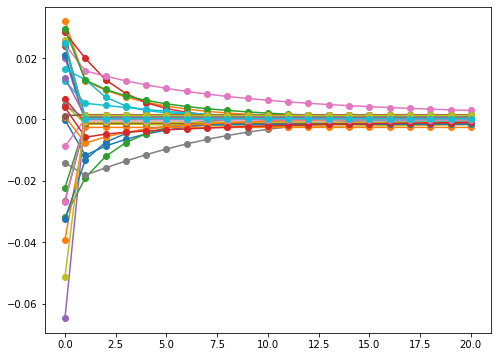

In [15]:
visualize_em(history,20)

## Part 2 : Exploring Single-Cell RNA-seq data

In a study published in 2015, Zeisel et al. used single-cell RNA-seq data to explore the cell diversity in the mouse brain. 
We will explore the data used for their study.
You can read more about it [here](https://science.sciencemag.org/content/347/6226/1138).

In [16]:
#reading single-cell RNA-seq data
lines_genes=[]
with open("Zeisel_expr.txt",'r') as file :
    lines_genes=file.readlines()

In [26]:
print(lines_genes[0][:300])
print(len(lines_genes))
print(len(lines_genes[2].split()))

0 0 0 3 0 0 3 0 0 0 2 0 0 0 0 0 4 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 2 0 0 1 2 6 7 2 0 0 0 2 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 3 13 2 1 2 1 0 3 2 0 0 2 1 0 0 2 3 6 0 1 5 0 0 1 1 4 0 4 0 1 0 0 1 2 5 0 0 5 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 3 1 0 0 2 0 0
19972
3005


Each line in the file Zeisel_expr.txt corresponds to one gene.
The columns correspond to different cells (notice that this is the opposite of how we looked at this matrix in class).
The entries of this matrix correspond to the number of reads mapping to a given gene in the corresponding cell.

In [22]:
# reading true labels for each cell
with open("Zeisel_labels.txt",'r') as file :
    true_labels = file.read().splitlines()

The study also provides us with true labels for each of the cells.
For each of the cells, the vector true_labels contains the name of the cell type.
There are nine different cell types in this dataset.

In [23]:
set(true_labels)

{'Astrocytes',
 'CA1 Pyrimidal',
 'Endothelial',
 'Ependymal',
 'Interneurons',
 'Microglia',
 'Mural',
 'Oligodentrocytes',
 'S1 Pyrimidal'}

## Graded Function 2 : prepare_data (10 marks) :

Purpose - To create a dataframe where each row corresponds to a specific cell and each column corresponds to the expressions levels of a particular gene across all cells. 
You should name the columns as "Gene_1", "Gene_2", and so on.

We will iterate through all the lines in lines_genes list created above, add 1 to each value and take log.

Each line will correspond to 1 column in the dataframe

Output - gene expression dataframe

### Note - All the values in the output dataframe should be rounded off to 5 digits after the decimal

In [31]:
%run main.py
module = Lab4()
data_df=module.prepare_data(lines_genes)
print(data_df.shape)
print(data_df.iloc[0:3,:5])

(3005, 19972)
   Gene_0   Gene_1   Gene_2  Gene_3   Gene_4
0     0.0  1.38629  1.38629     0.0  0.69315
1     0.0  0.69315  0.69315     0.0  0.69315
2     0.0  0.00000  1.94591     0.0  0.69315


## Expected Output :

``(3005, 19972)``

``   Gene_0    Gene_1    Gene_2   Gene_3    Gene_4``
   
``0     0.0  1.38629  1.38629     0.0  0.69315``

``1     0.0  0.69315  0.69315     0.0  0.69315``

``2     0.0  0.00000  1.94591     0.0  0.69315``

## Graded Function 3 : identify_less_expressive_genes (10 marks)

Purpose : To identify genes (columns) that are expressed in less than 25 cells. We will create a list of all gene columns that have values greater than 0 for less than 25 cells.

Input - gene expression dataframe

Output - list of column names which are expressed in less than 25 cells

In [34]:
%run main.py
module = Lab4()
drop_columns = module.identify_less_expressive_genes(data_df)
print(len(drop_columns))
print(drop_columns[:10])

5120
['Gene_28', 'Gene_126', 'Gene_145', 'Gene_146', 'Gene_151', 'Gene_152', 'Gene_167', 'Gene_168', 'Gene_170', 'Gene_173']


## Expected Output : 

``5120`` 

``['Gene_28', 'Gene_126', 'Gene_145', 'Gene_146', 'Gene_151', 'Gene_152', 'Gene_167', 'Gene_168', 'Gene_170', 'Gene_173']``

### Filtering less expressive genes

We will now create a new dataframe in which genes which are expressed in less than 25 cells will not be present

In [35]:
df_new = data_df.drop(drop_columns, axis=1)

In [36]:
df_new.head()

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_19947,Gene_19948,Gene_19951,Gene_19952,Gene_19953,Gene_19955,Gene_19956,Gene_19957,Gene_19959,Gene_19960
0,0.00000,1.38629,1.38629,0.0,0.69315,0.0,0.00000,2.48491,0.69315,0.0,...,2.07944,0.0,0.00000,0.0,0.0,1.79176,0.0,0.0,0.0,0.00000
1,0.00000,0.69315,0.69315,0.0,0.69315,0.0,0.00000,0.00000,0.00000,0.0,...,0.69315,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000
2,0.00000,0.00000,1.94591,0.0,0.69315,0.0,1.09861,3.25810,0.69315,0.0,...,0.69315,0.0,1.09861,0.0,0.0,1.38629,0.0,0.0,0.0,2.07944
3,1.38629,1.09861,1.60944,0.0,0.00000,0.0,1.38629,0.69315,0.00000,0.0,...,1.38629,0.0,0.69315,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000
4,0.00000,1.09861,0.69315,0.0,0.00000,0.0,0.00000,2.39790,0.00000,0.0,...,0.00000,0.0,1.60944,0.0,0.0,1.38629,0.0,0.0,0.0,0.00000


## Graded Function 4 :  perform_pca (10 marks)

Pupose - Perform Principal Component Analysis on the new dataframe and take the top 50 principal components

Input - df_new

Output - numpy array containing the top 50 principal components of the data.

### Note - All the values in the output should be rounded off to 5 digits after the decimal

### Note - Please use random_state=365 for the PCA object you will create

In [39]:
%run main.py
module = Lab4()
pca_data=module.perform_pca(df_new)
print(pca_data.shape)
print(type(pca_data))
print(pca_data[0:3,:5])

(3005, 50)
<class 'numpy.ndarray'>
[[26.97148 -2.7244   0.62163 25.90148 -6.24736]
 [26.49135 -1.58774 -4.79315 24.01094 -7.25618]
 [47.82664  5.06799  2.15177 30.24367 -3.38878]]


## Expected Output : 

``(3005, 50)``

``<class 'numpy.ndarray'>``

``[[26.97148  -2.7244  0.62163 25.90148 -6.24736]``

`` [26.49135 -1.58774 -4.79315 24.01094 -7.25618]``
 
`` [47.82664  5.06799  2.15177 30.24367 -3.38878]]``

## (Non-graded) Function 5 :  perform_tsne

Pupose - Perform t-SNE on the pca_data and obtain 2 t-SNE components

We will use TSNE class of the sklearn.manifold package. Use random_state=1000 and perplexity=50

Documenation can be found here - https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Input - pca_data

Output - numpy array containing the top 2 tsne components of the data.

**Note: This function will not be graded because of the random nature of t-SNE.**

In [40]:
%run main.py
module = Lab4()
tsne_data50 = module.perform_tsne(pca_data)
print(tsne_data50.shape)
print(tsne_data50[:3,:])

(3005, 2)
[[ 19.031317 -45.3434  ]
 [ 19.188553 -44.945473]
 [ 17.369982 -47.997364]]


## Expected Output :

(These numbers can deviate a bit depending on your sklearn)

``(3005, 2)``

``[[ 15.069608 -47.535984]``

`` [ 15.251476 -47.172073]``
 
`` [ 13.3932   -49.909657]]``

D:\Programs\miniconda3\envs\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


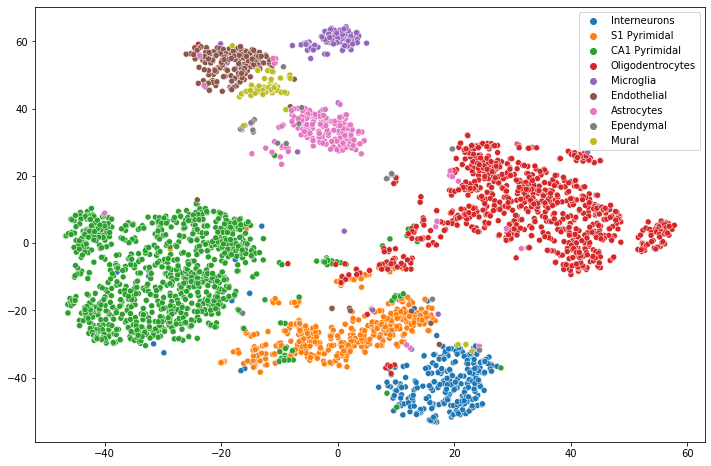

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(tsne_data50[:,0], tsne_data50[:,1], hue=true_labels)
plt.show()

Notice that the different cell types form clusters (which can be easily visualized on the t-SNE space).
Zeisel et al. performed clustering on this data in order to identify and label the different cell types.

You can try using clustering methods (such as k-means and GMM) to cluster the single-cell RNA-seq data of Zeisel at al. and see if your results agree with theirs!